In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Loading the Data & Forming the Dataframe

In [2]:
local_path_target = '/mnt/g/Meine Ablage/raw_data/Target/energy_generation_data/df_deutschland.csv'
local_path_feature = "/mnt/g/Meine Ablage/raw_data/Features/DATAFRAMES/winddailyofeverystation.csv"

data_target = pd.read_csv(local_path_target)
data_feature = pd.read_csv(local_path_feature)

data_target['Date'] = pd.to_datetime(data_target.Date)

In [3]:
data_target.head()

,Date,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
0,2015-01-01,11.989583,1278.427083,75.531250,50hertz
1,2015-01-02,9.947917,2555.510417,17.677083,50hertz
2,2015-01-03,11.281250,2308.958333,27.354167,50hertz
3,2015-01-04,11.354167,2079.041667,49.750000,50hertz
4,2015-01-05,4.104167,1333.343750,20.187500,50hertz


In [4]:
generation_df = data_target.groupby(by=data_target['Date'].dt.date).sum()
generation_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01,130.437500,3112.937500,178.093750
2015-01-02,107.791667,6163.031250,80.979167
2015-01-03,126.270833,4761.447917,75.510417
2015-01-04,120.364583,3948.895833,208.354167
2015-01-05,80.937500,2288.208333,276.479167


In [5]:
wind_df = generation_df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
wind_df

Date
2015-01-01    3243.375000
2015-01-02    6270.822917
2015-01-03    4887.718750
2015-01-04    4069.260417
2015-01-05    2369.145833
                 ...     
2020-12-28    3283.010417
2020-12-29    3296.229167
2020-12-30    4859.833333
2020-12-31    3267.677083
2021-01-01     842.864583
Length: 2193, dtype: float64

In [6]:
data_feature.head()

,Date,90,183,197,198,232,282,298,303,342,...,1587,1605,161,1612,1639,164,1684,1691,1694,1757
0,2015-01-01,3.2,11.9,3.2,4.6,1.7,1.3,6.9,4.7,5.2,...,1.7,2.9,2.0,5.3,2.4,5.0,4.1,2.7,5.3,5.3
1,2015-01-02,6.8,16.3,3.2,7.4,4.2,2.7,11.0,8.1,8.2,...,3.7,4.9,4.3,8.6,4.7,7.8,8.2,5.9,8.7,8.3
2,2015-01-03,4.2,14.4,3.2,6.6,3.4,1.9,9.7,8.3,5.7,...,2.7,5.2,1.9,6.1,2.9,8.6,7.2,4.2,7.6,6.9
3,2015-01-04,4.2,11.5,3.2,5.4,5.4,2.7,6.6,5.8,4.6,...,4.1,5.3,2.1,6.9,2.9,8.0,5.4,5.1,5.9,5.6
4,2015-01-05,3.1,3.4,3.2,4.1,3.1,1.9,3.9,5.3,3.6,...,3.1,4.2,1.0,5.0,2.9,4.8,4.7,3.3,4.5,3.5


In [7]:
data_feature["Date"]

0       2015-01-01
1       2015-01-02
2       2015-01-03
3       2015-01-04
4       2015-01-05
           ...    
2307    2021-04-26
2308    2021-04-27
2309    2021-04-28
2310    2021-04-29
2311    2021-04-30
Name: Date, Length: 2312, dtype: object

In [8]:
data_feature.set_index(data_feature["Date"])
data_feature.drop(index = 0)

,Date,90,183,197,198,232,282,298,303,342,...,1587,1605,161,1612,1639,164,1684,1691,1694,1757
1,2015-01-02,6.8,16.3,3.2,7.4,4.2,2.7,11.0,8.1,8.2,...,3.7,4.9,4.3,8.6,4.7,7.8,8.2,5.9,8.7,8.3
2,2015-01-03,4.2,14.4,3.2,6.6,3.4,1.9,9.7,8.3,5.7,...,2.7,5.2,1.9,6.1,2.9,8.6,7.2,4.2,7.6,6.9
3,2015-01-04,4.2,11.5,3.2,5.4,5.4,2.7,6.6,5.8,4.6,...,4.1,5.3,2.1,6.9,2.9,8.0,5.4,5.1,5.9,5.6
4,2015-01-05,3.1,3.4,3.2,4.1,3.1,1.9,3.9,5.3,3.6,...,3.1,4.2,1.0,5.0,2.9,4.8,4.7,3.3,4.5,3.5
5,2015-01-06,2.1,6.3,3.2,1.6,1.3,1.0,4.7,3.5,2.7,...,1.9,2.7,1.5,4.5,2.9,3.7,2.1,2.6,2.8,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,2021-04-26,2.3,3.6,2.3,2.6,4.2,2.9,2.5,1.5,1.6,...,3.1,1.8,2.1,2.7,3.5,2.8,2.1,2.5,2.2,2.7
2308,2021-04-27,2.4,2.6,2.9,4.2,3.7,2.5,3.4,2.7,3.0,...,3.9,2.9,1.9,4.6,3.6,2.4,3.6,4.0,2.1,3.0
2309,2021-04-28,2.7,4.7,2.4,2.9,1.7,1.6,5.4,2.9,2.4,...,2.2,2.9,2.3,2.9,3.1,3.1,2.7,2.9,1.9,4.6
2310,2021-04-29,5.2,8.8,4.9,5.1,3.5,2.8,3.2,3.6,4.9,...,3.1,2.5,3.6,5.3,5.3,2.8,4.1,3.9,2.2,2.8


In [9]:
data_feat_mean = np.log(data_feature.mean(axis=1))
data_feat_mean_log = np.log(data_feature.mean(axis=1))

In [10]:
X_train = data_feat_mean.loc[:364]

## Statistical Exploration

### Building Test, Train set

In [11]:
wind_df_train = wind_df.loc[:dt.date(2015,12,31)]
wind_df_test = wind_df.loc[dt.date(2016,1,1):dt.date(2016,3,1)]

wind_df_train_log = np.log(wind_df.loc[:dt.date(2016,1,1)])
wind_df_test_log = np.log(wind_df.loc[dt.date(2016,1,1):dt.date(2016,3,1)])

y = np.log(wind_df.loc[:dt.date(2016,3,1)])
y_train = np.log(wind_df_train)
y_test = np.log(wind_df_test)

<AxesSubplot:>

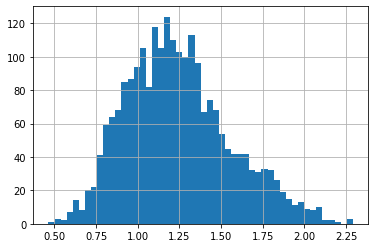

In [12]:
data_feat_mean.hist(bins=50)

Text(0, 0.5, 'Wind in meter/seconds')

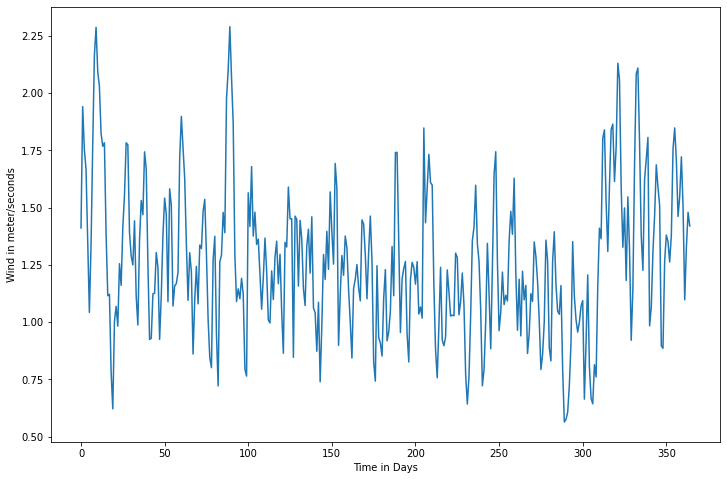

In [13]:
plt.subplots(figsize=(12,8))
X_train.plot()
plt.xlabel("Time in Days")
plt.ylabel("Wind in meter/seconds")

In [14]:
adfuller(data_feat_mean)[1]

3.274761008757043e-07

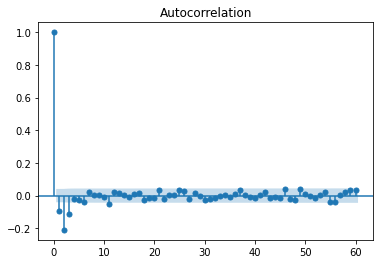

In [15]:
plot_acf(data_feat_mean.diff(1).dropna(), lags=60);

In [16]:
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m)
    if d > 0:
        for i in range(d):
            y = y.diff(1)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 50, ax=ax2);
    plot_pacf(y, lags=50, ax=ax3, color='r');
    plt.show()

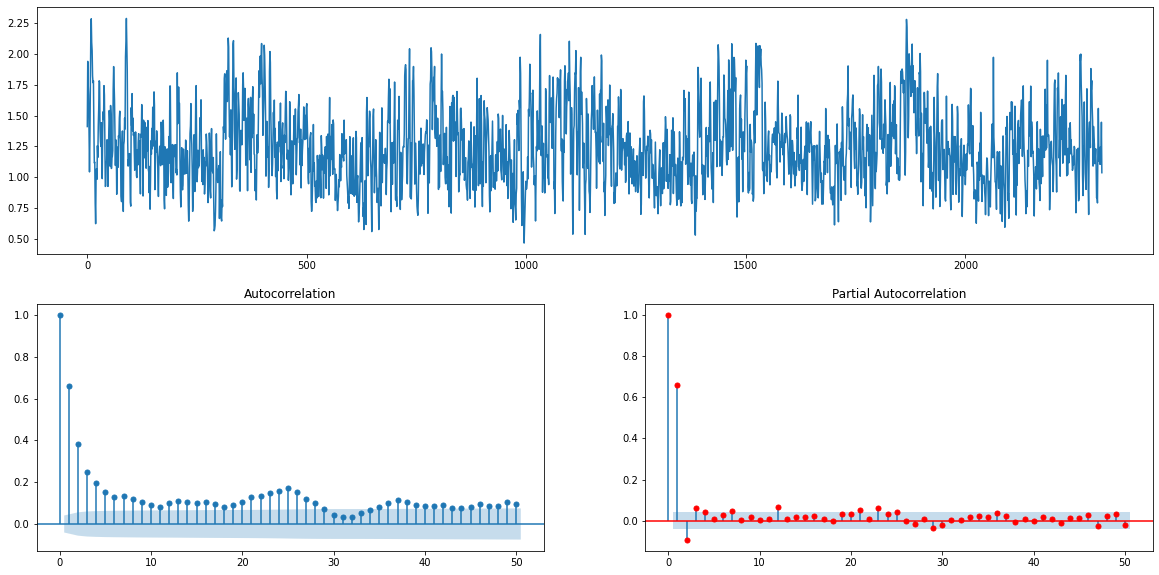

In [17]:
plot_autocorrelation(data_feat_mean, D=0, m=365*5)

In [18]:
import pmdarima as pm

smodel = pm.auto_arima(y_train, m=12, X=X_train.to_numpy().reshape(-1,1),
                       start_p=0, max_p=2,
                       start_q=0, max_q=5,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=164.613, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=161.629, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=154.510, Time=2.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=133.812, Time=3.66 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=159.629, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=132.472, Time=0.15 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=134.002, Time=2.27 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=133.777, Time=4.78 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=67.869, Time=0.33 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=69.601, Time=5.63 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=69.534, Time=4.38 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=71.858, Time=4.90 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=in

## Model

In [31]:
sarimax = SARIMAX(endog=y_train, exog=pd.DataFrame(X_train).set_index(y_train.index), order=(1,1,3)).fit()

/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [32]:
y_test.shape

(61,)

In [33]:
exog_test = pd.DataFrame(data_feat_mean.loc[366:426]).set_index(y_test.index)

y_pred = sarimax.forecast(y_test.shape[0], exog=exog_test)[0]

In [34]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [35]:
forecast = sarimax.forecast(len(y_test), exog=exog_test, alpha=0.05)

In [36]:
forecast

2016-01-01    8.492196
2016-01-02    8.608550
2016-01-03    8.349474
2016-01-04    7.918273
2016-01-05    7.415215
                ...   
2016-02-26    7.337348
2016-02-27    7.802809
2016-02-28    8.317734
2016-02-29    7.933763
2016-03-01    8.551327
Freq: D, Name: predicted_mean, Length: 61, dtype: float64

In [37]:
y_test

Date
2016-01-01    7.029687
2016-01-02    8.330407
2016-01-03    8.356777
2016-01-04    7.997292
2016-01-05    7.682564
                ...   
2016-02-26    6.886766
2016-02-27    7.063316
2016-02-28    7.554340
2016-02-29    7.866103
2016-03-01    7.798010
Length: 61, dtype: float64

In [38]:
(forecast - y_test).mean()

0.2402473131335646

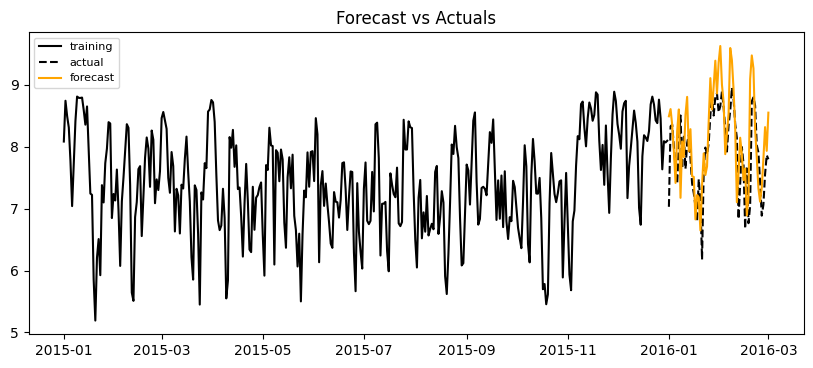

In [39]:
plot_forecast(forecast, y_train, y_test)

In [40]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
hourly_baseline = mean_absolute_percentage_error(np.exp(y_test), np.exp(forecast))
hourly_baseline

73.551822671429

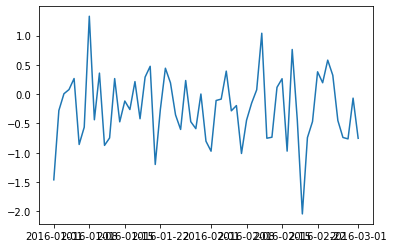

In [42]:
plt.plot(y_test - forecast)